# Imports

In [1]:
from pathlib import Path
from dateutil.tz import gettz
from datetime import datetime, timedelta
from numpy import arange
from matplotlib.pyplot import subplots, tight_layout
from matplotlib.dates import DateFormatter
from matplotlib.ticker import AutoMinorLocator, StrMethodFormatter
from pandas import DataFrame, concat
from stk_guide.pipeline.stages.preprocessing import PricePreprocessor
from stk_guide.entities.prices import PricesEnum
from stk_guide.entities.stock import Stock
from stk_guide.entities.stocks import Stocks
from stk_guide.ml.encoding.algorithms import MinMaxCoder
from stk_guide.ml.encoding.encoder import Encoder
from stk_guide.ml.models.gbr import GbrModel
from stk_guide.ml.models.sequence import SequenceModel
from stk_guide.pipeline.pipeline import Pipeline
from stk_guide.pipeline.pipeline_stages import PipelineStages
from stk_guide.pipeline.stages.predicting import PricePredictor
from stk_guide.pipeline.stages.training import ClosePriceTrainer
from stk_guide.strategies.historic_price import HistoricPrice
from stk_guide.entities.options import OptionsEnum
from stk_guide.ml.scoring.scorer import RatingsScorer
from keras import saving
import seaborn as sns
sns.set_style("whitegrid")

# PREDICT Price History

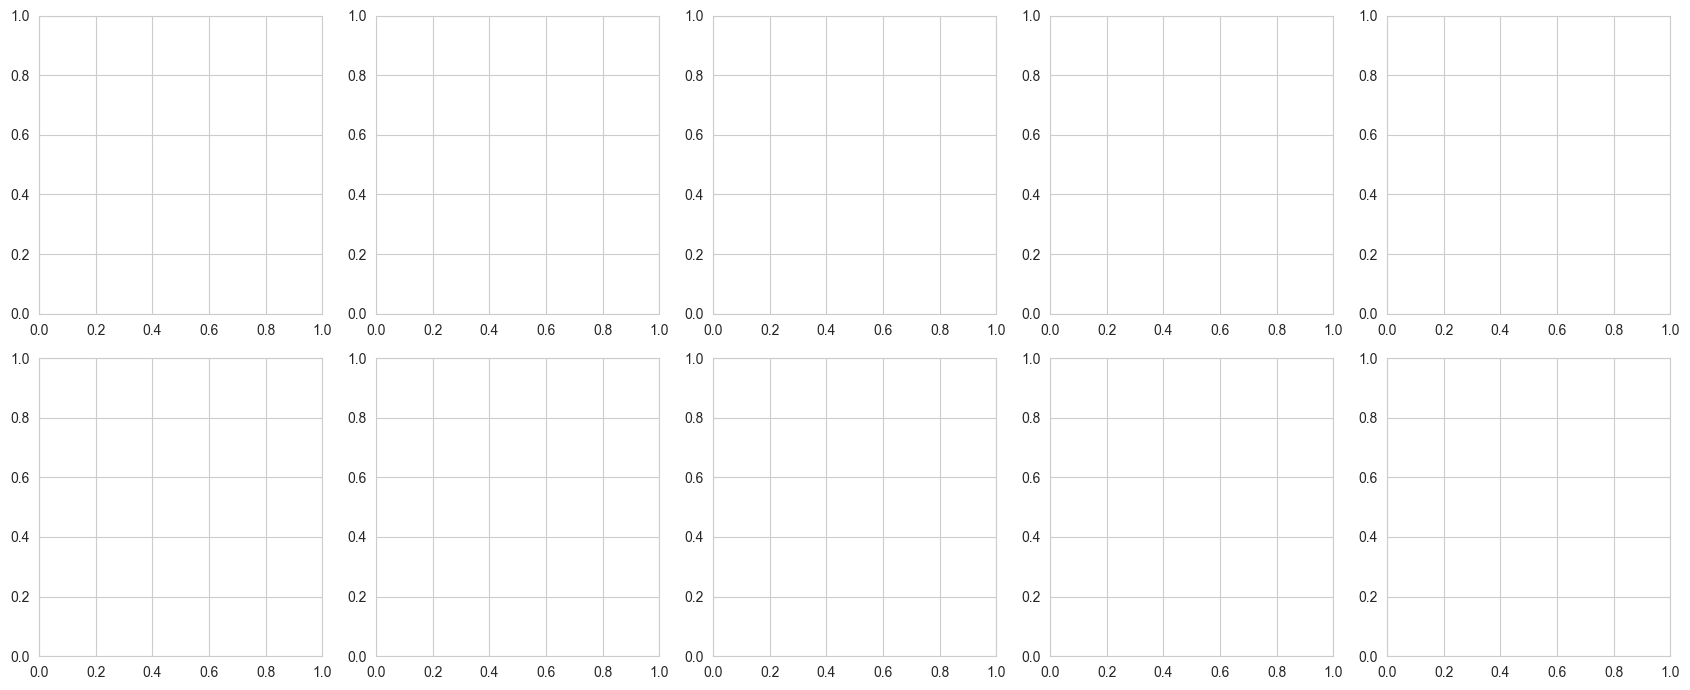

In [2]:
from stk_guide.ml.models.model import Model
if True:
    days_back = 1; tz = gettz("America/New_York")
    stocksObj = Stocks([Stock("AAPL"), Stock("INTC"), Stock("META"), Stock("NVDA"), Stock("GOOGL"), Stock("AMZN"), Stock("MSFT")])
    one_workday = [datetime(2025,1,28,9,30,tzinfo=tz) + timedelta(minutes=imin) for imin in range(0,7*60)]
    today_workday = [datetime(2025,1,29,9,30,tzinfo=tz) + timedelta(minutes=imin) for imin in range(0,7*60)]
    projs = DataFrame({PricesEnum.DATETIME.value: today_workday})
    fig, axes = subplots(nrows=2,ncols=5,figsize=(17,7)); axes = axes.reshape(-1)
    for idx, stock in enumerate(stocksObj):
        stock.populate_prices(days_back=days_back, interval="1m")
        path = f"price_history_models/{stock}_jan29_1m.keras"
        if not Path(path).exists():
            continue
        model = saving.load_model(path)
        preprocessor = HistoricPrice(None).setup_preprocessor(stock.prices.features(), projs)
        _projs = preprocessor(projs)
        preds = model.predict(_projs).squeeze()
        current = stock.prices.to_frame()
        sns.scatterplot(x=current.index, y=current.Close, ax=axes[idx]); axes[idx].set(title=str(stock), xlabel="date", ylabel="price")
        sns.scatterplot(x=projs[PricesEnum.DATETIME.value], y=preds, ax=axes[idx], color="green"); 
        axes[idx].xaxis.set_major_formatter(DateFormatter("%b%d-%H", tz=tz))
        axes[idx].tick_params(axis='x', rotation=90)
    tight_layout()    

# PREDICT Options

In [3]:
sns.set_style("whitegrid")
today = datetime.now().strftime("options_%Y.%m.%d")
today_calls = []; 
stocksObj = []
for idx, symbol in enumerate(["AAPL","NVDA","META","INTC","AMZN","GOOGL","MSFT","AVGO", "RDDT", "V"]):
    stock = Stock(symbol)
    stocksObj.append(stock)
    stock.populate_options(max_number=6)

# Analysis

## Price Trending

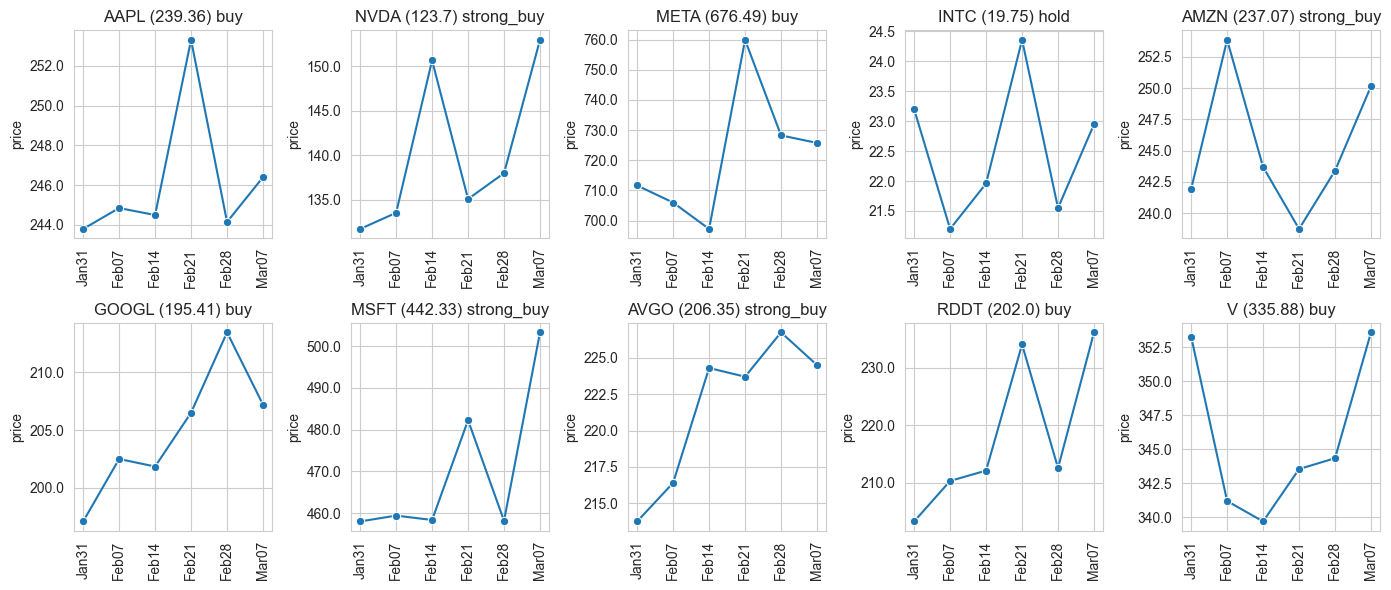

In [4]:
today = datetime.now().strftime("options_%Y.%m.%d")
fig, ax = subplots(nrows=2,ncols=5,figsize=(14,6)); ax = ax.reshape(-1)
today_calls = []; 
for idx, stock in enumerate(stocksObj):
    calls,puts = stock.options.sumarize_calls(weights={}), stock.options.sumarize_puts()
    sns.lineplot(calls,x=OptionsEnum.EXPIRATION,y=OptionsEnum.PROJECTED_PRICE_v1,marker="o",ax=ax[idx])
    ylim = [10,30] if stock.symbol == "INTC" else [0.1,1000]
    ax[idx].set(title=f"{stock.symbol} ({stock.info['currentPrice']}) {stock.info['recommendationKey']}",ylabel="price", xlabel="")#, ylim=ylim);
    dates = [dd.strftime("%b%d") for dd in calls[OptionsEnum.EXPIRATION.value]]
    ax[idx].set_xticks(calls[OptionsEnum.EXPIRATION.value], dates, rotation=90)
    ax[idx].yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
tight_layout()

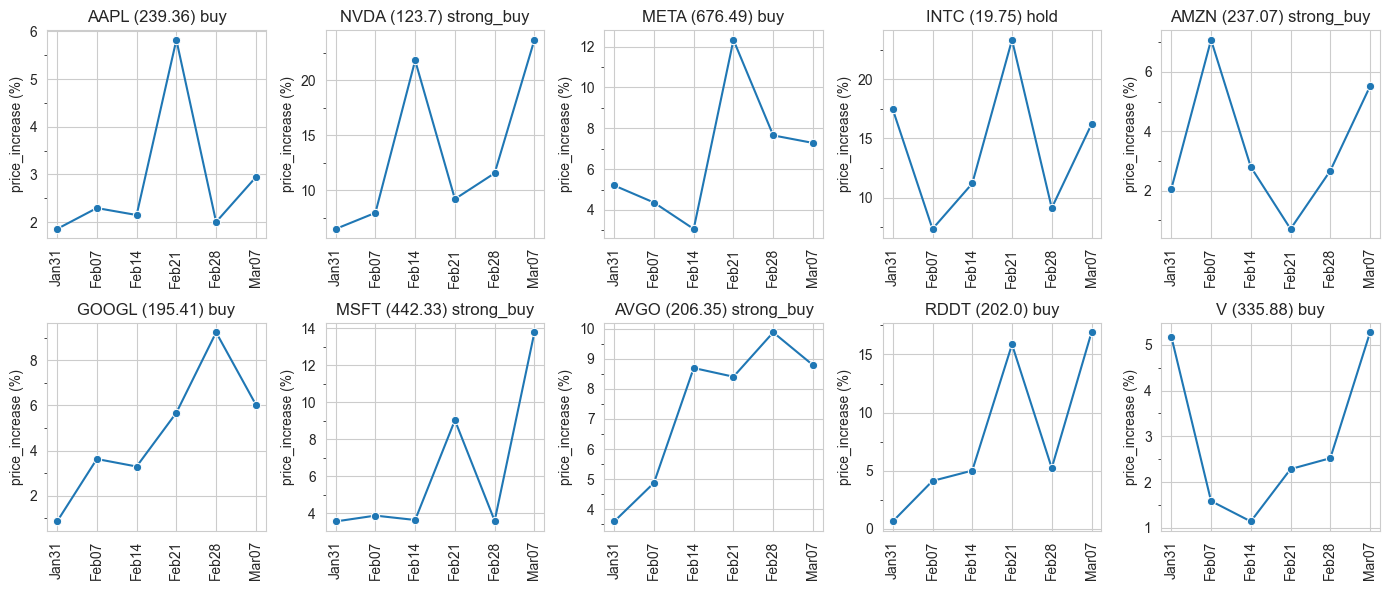

In [5]:
sns.set_style("whitegrid")
today = datetime.now().strftime("options_%Y.%m.%d")
fig, ax = subplots(nrows=2,ncols=5,figsize=(14,6)); ax = ax.reshape(-1)
today_calls = []; 
for idx, stock in enumerate(stocksObj):
    calls,puts = stock.options.sumarize_calls(weights={}), stock.options.sumarize_puts()
    calls[OptionsEnum.PROJECTED_PRICE_v1] = (calls.loc[:,OptionsEnum.PROJECTED_PRICE_v1]/stock.info['currentPrice'] - 1)*100
    sns.lineplot(calls,x=OptionsEnum.EXPIRATION,y=OptionsEnum.PROJECTED_PRICE_v1,marker="o",ax=ax[idx])
    ax[idx].set(title=f"{stock.symbol} ({stock.info['currentPrice']}) {stock.info['recommendationKey']}",ylabel="price_increase (%)", xlabel="")#, ylim=ylim);
    dates = [dd.strftime("%b%d") for dd in calls[OptionsEnum.EXPIRATION.value]]
    ax[idx].set_xticks(calls[OptionsEnum.EXPIRATION.value], dates, rotation=90)
    ax[idx].yaxis.set_minor_locator(AutoMinorLocator(2)); ax[idx].tick_params(which='minor',bottom=True, left=True)
tight_layout()

## Recommendations

In [6]:
# GET THE DATA
news, rratings, fratings, recom = [], [], [], []
stocks = ["AAPL","NVDA","META","INTC","AMZN","GOOGL","MSFT","AVGO", "RDDT", "V"]
for idx, symbol in enumerate(stocks):
    stock = Stock(symbol)
    rratings.append(stock.robinhood_ratings[0].to_frame())
    fratings.append(stock.finhub_ratings[0].to_frame())
    recom.append(stock.info["recommendationKey"])
robin_ratings = concat(rratings); robin_ratings.index = stocks
fin_ratings = concat(fratings); fin_ratings.index = stocks
recom = DataFrame(recom, index=stocks)


In [7]:
# SCORE LATEST
robin_results, fin_results = [],[]; weights = arange(0,1.1,0.1);
for ww in weights:
    scr = RatingsScorer(hold_weight=ww)
    df = scr(robin_ratings).to_frame(); df["stock"] = robin_ratings.index.to_list(); df["holdw"] = ww
    robin_results.append(df)
    df = scr(fin_ratings).to_frame(); df["stock"] = fin_ratings.index.to_list(); df["holdw"] = ww
    fin_results.append(df)
robin_results = concat(robin_results); robin_results["src"] = "Robinhood"
fin_results = concat(fin_results); fin_results["src"] = "Finhub"
robin_results["scores"] = 1 - robin_results["scores"]
fin_results["scores"] = 1 - fin_results["scores"]

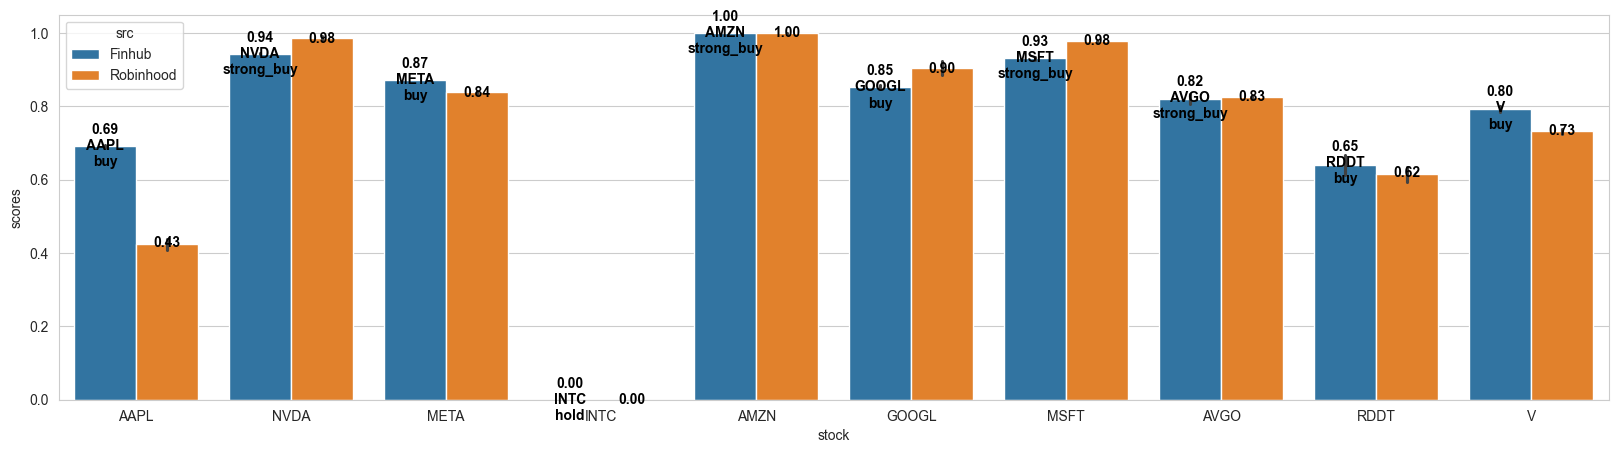

In [8]:
# PLOT
results = concat([robin_results, fin_results])
fig, ax = subplots(nrows=1,ncols=1,figsize=(20,5)); names = ["Finhub","Robinhood"]
all_vals = results.groupby(["src","stock"]).median();
sns.barplot(results, x="stock", y="scores", hue="src", gap=0.01, ax=ax, hue_order=names);
lines = ax.get_lines() 
for idx, line in enumerate(lines):
    x = line.get_xdata()[0]
    name = stocks[idx%10]; src = names[0 if idx < 10 else 1]
    value = all_vals.loc[(src, name),"scores"]
    rmd = recom.loc[name]
    if idx < 10:
        text = ax.text(x, value, f'{value:.2f}\n{name}\n{rmd.iloc[0]}', ha='center', va='center',fontweight='bold', color='black')
    else :
        text = ax.text(x, value, f'{value:.2f}', ha='center', va='center',fontweight='bold', color='black')


## Calls / Puts Analysis

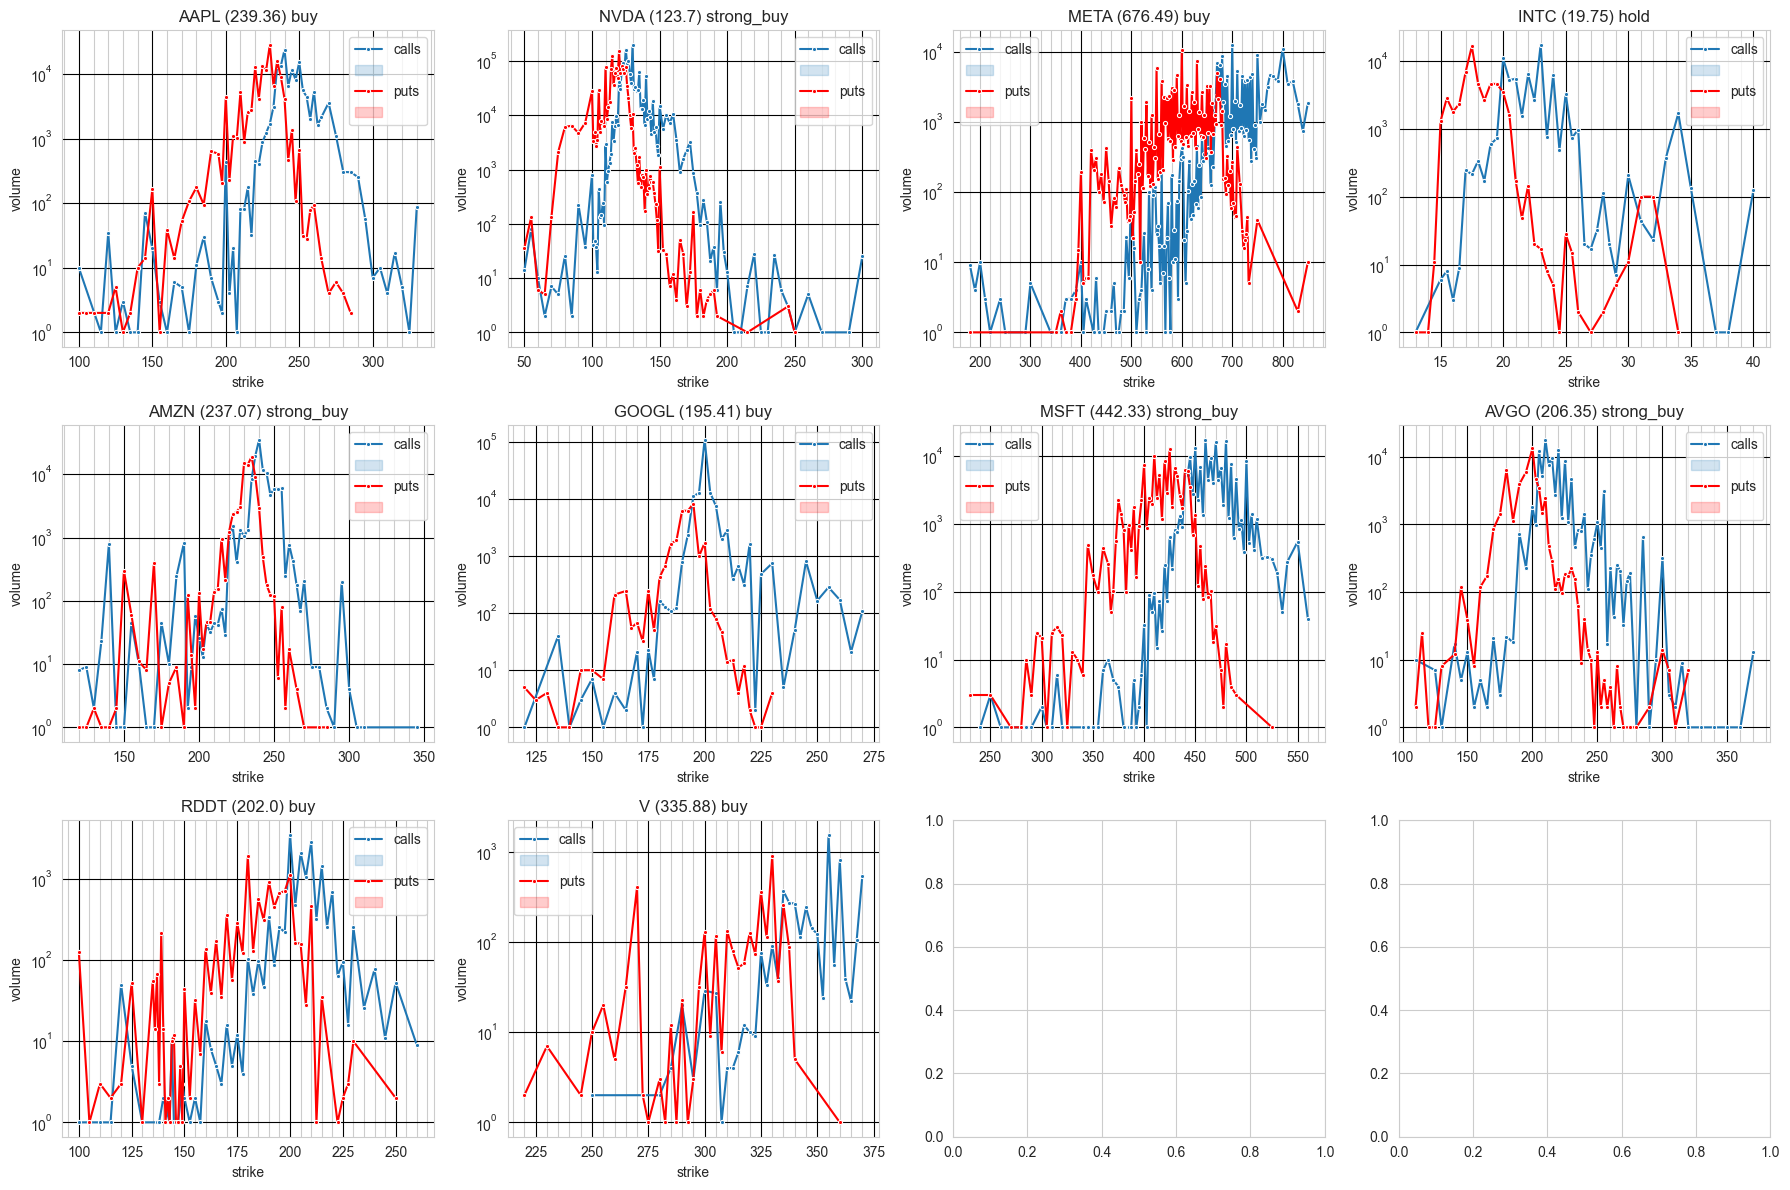

In [9]:
date = datetime(2025,1,31).date()
fig, ax = subplots(nrows=3,ncols=4,figsize=(18,12)); ax = ax.reshape(-1)
to_plot = OptionsEnum.VOLUME
for idx, stock in enumerate(stocksObj):
    calls = stock.options.calls.dropna(); puts = stock.options.puts.dropna()
    calls = calls[(calls[OptionsEnum.EXPIRATION.value] == date) & (calls[to_plot] > 0)]
    puts = puts[(puts[OptionsEnum.EXPIRATION.value] == date) & (puts[to_plot] > 0)]
    sns.lineplot(calls,x=OptionsEnum.STRIKE,y=to_plot,marker=".",ax=ax[idx])
    sns.lineplot(puts,x=OptionsEnum.STRIKE,y=to_plot,marker=".",ax=ax[idx], color="red")
    for _ax in [ax[idx]]:
        _ax.set(title=f"{stock.symbol} ({stock.info['currentPrice']}) {stock.info['recommendationKey']}",ylabel=f"{to_plot}", xlabel="strike", yscale="log")
        _ax.grid(color="black")
        _ax.xaxis.set_minor_locator(AutoMinorLocator(5)); _ax.xaxis.set_tick_params(which='minor',gridOn=True);
        _ax.legend(["calls",None, "puts", None])
tight_layout()

# FinHub Rating Change

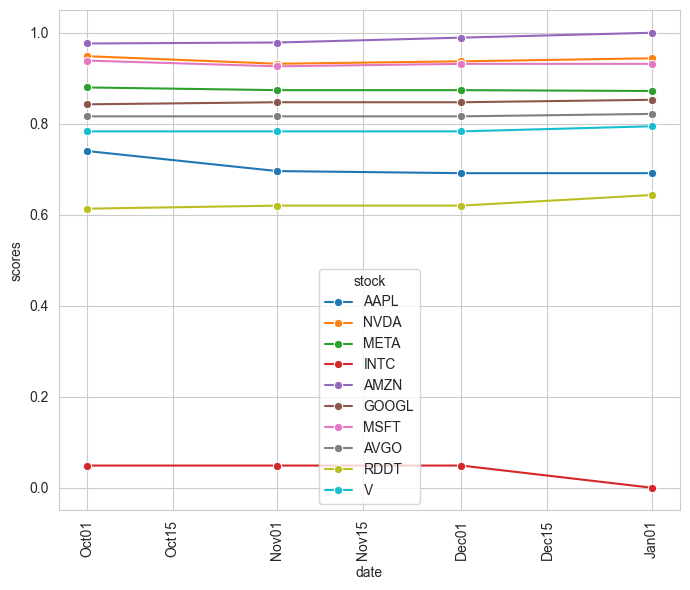

In [10]:
# GET THE DATA
fratings = []
stocks = ["AAPL","NVDA","META","INTC","AMZN","GOOGL","MSFT","AVGO", "RDDT", "V"]
for idx, symbol in enumerate(stocks):
    stock = Stock(symbol)
    _fratings = concat(rating.to_frame() for rating in stock.finhub_ratings)
    _fratings["stock"] = symbol
    fratings.append(_fratings)
fin_ratings = concat(fratings).reset_index(drop=True); 
scr = RatingsScorer(hold_weight=0.5)
fin_ratings["scores"] = 1 - scr(fin_ratings)
fig, ax = subplots(nrows=1,ncols=1,figsize=(7,6));
sns.lineplot(fin_ratings,x="date",y="scores",marker="o",ax=ax, hue="stock")
[xx.set_rotation(90) for xx in ax.get_xticklabels()]; ax.xaxis.set_major_formatter(DateFormatter("%b%d"))
tight_layout()

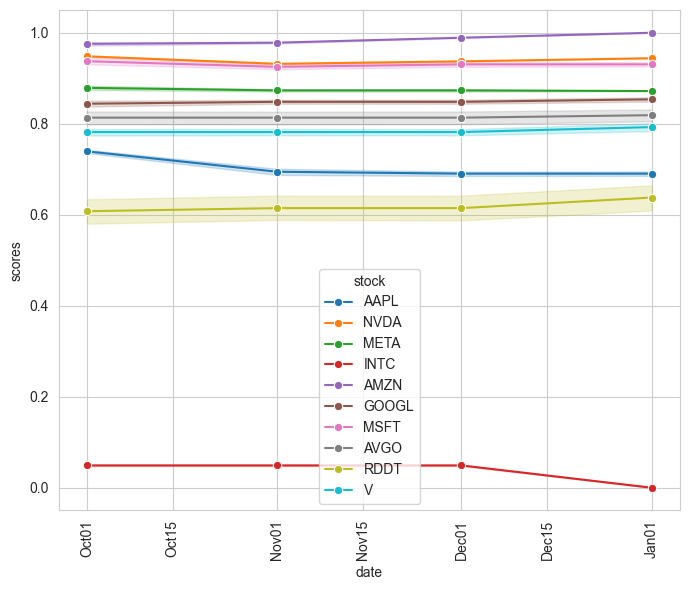

In [34]:
fin_ratings = concat(fratings).reset_index(drop=True); weights = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
for ww in weights:
    scr = RatingsScorer(hold_weight=ww)
    fin_ratings[f"scores_hw{ww}"] = 1 - scr(fin_ratings)
from pandas import melt
fin_ratings = melt(fin_ratings, id_vars = ["stock", "date"],value_vars=[f"scores_hw{ww}" for ww in weights], value_name="scores")
fig, ax = subplots(nrows=1,ncols=1,figsize=(7,6));
sns.lineplot(fin_ratings,x="date",y="scores",marker="o",ax=ax, hue="stock")
[xx.set_rotation(90) for xx in ax.get_xticklabels()]; ax.xaxis.set_major_formatter(DateFormatter("%b%d"))
tight_layout()